## 卷积神经网络（LeNet）
通过之前⼏节，我们学习了构建⼀个完整卷积神经⽹络的所需组件。回想⼀下，之前我们将softmax回归模型
和多层感知机模型应⽤于Fashion-MNIST数据集中的服装图⽚。为了能够应⽤softmax回归
和多层感知机，我们⾸先将每个⼤⼩为28 × 28的图像展平为⼀个784维的固定⻓度的⼀维向量，然后⽤全连
接层对其进⾏处理。⽽现在，我们已经掌握了卷积层的处理⽅法，我们可以在图像中保留空间结构。同时，⽤
卷积层代替全连接层的另⼀个好处是：模型更简洁、所需的参数更少。  

本节将介绍LeNet，它是最早发布的卷积神经⽹络之⼀，因其在计算机视觉任务中的⾼效性能⽽受到⼴泛关
注。这个模型是由AT&T⻉尔实验室的研究员Yann LeCun在1989年提出的（并以其命名），⽬的是识别图像
(LeCun et al., 1998)中的⼿写数字。当时，Yann LeCun发表了第⼀篇通过反向传播成功训练卷积神经⽹络的
研究，这项⼯作代表了⼗多年来神经⽹络研究开发的成果。

当时，LeNet取得了与⽀持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流⽅
法。LeNet被⼴泛⽤于⾃动取款机（ATM）机中，帮助识别处理⽀票的数字。

## LeNet
总体来看，LeNet（LeNet-5）由两个部分组成：  
* 卷积编码器：由两个卷积层组成;
* 全连接层密集块：由三个全连接层组成。  

框架如下所示：  
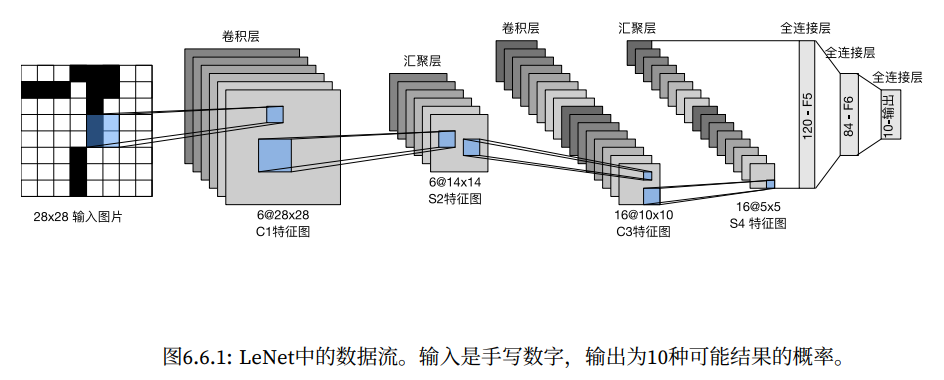

每个卷积块中的基本单元是⼀个卷积层、⼀个sigmoid激活函数和平均汇聚层。请注意，虽然ReLU和最⼤汇
聚层更有效，但它们在20世纪90年代还没有出现。每个卷积层使⽤5 × 5卷积核和⼀个sigmoid激活函数。这
些层将输⼊映射到多个⼆维特征输出，通常同时增加通道的数量。第⼀卷积层有6个输出通道，⽽第⼆个卷
积层有16个输出通道。每个2 × 2池操作（步幅2）通过空间下采样将维数减少4倍。卷积的输出形状由批量⼤
⼩、通道数、⾼度、宽度决定。

为了将卷积块的输出传递给稠密块，我们必须在⼩批量中展平每个样本。换⾔之，我们将这个四维输⼊转换
成全连接层所期望的⼆维输⼊。这⾥的⼆维表⽰的第⼀个维度索引⼩批量中的样本，第⼆个维度给出每个样
本的平⾯向量表⽰。LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执⾏分类任务，
所以输出层的10维对应于最后输出结果的数量。

下⾯的LeNet代码，可以看出⽤深度学习框架实现此类模型⾮常简单。我们只需要实例化⼀
个Sequential块并将需要的层连接在⼀起。

In [15]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), #卷积层
    nn.AvgPool2d(kernel_size=2, stride=2), #平均汇聚层
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), #卷积层
    nn.AvgPool2d(kernel_size=2, stride=2), #平均汇聚层
    nn.Flatten(), # 将图像展平为一维张量
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(), # 激活函数
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

我们对原始模型做了⼀点⼩改动，去掉了最后⼀层的⾼斯激活。除此之外，这个⽹络与最初的LeNet-5⼀致。
下⾯，我们将⼀个⼤⼩为28 × 28的单通道（⿊⽩）图像通过LeNet。通过在每⼀层打印输出的形状，我们可
以检查模型，以确保其操作与我们期望的下图⼀致。  
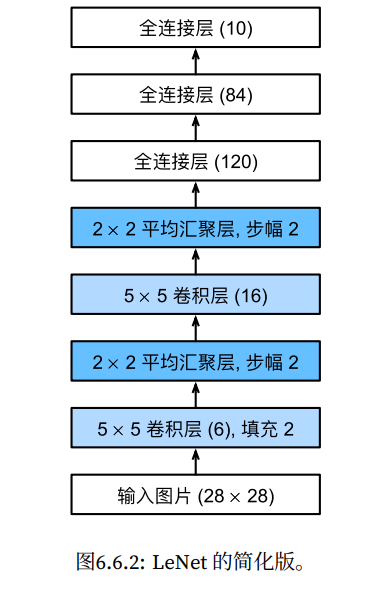


In [16]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


请注意，在整个卷积块中，与上⼀层相⽐，每⼀层特征的⾼度和宽度都减⼩了。第⼀个卷积层使⽤2个像素的
填充，来补偿5 × 5卷积核导致的特征减少。相反，第⼆个卷积层没有填充，因此⾼度和宽度都减少了4个像
素。随着层叠的上升，通道的数量从输⼊时的1个，增加到第⼀个卷积层之后的6个，再到第⼆个卷积层之后
的16个。同时，每个汇聚层的⾼度和宽度都减半。最后，每个全连接层减少维数，最终输出⼀个维数与结果
分类数相匹配的输出。

## 模型训练
已经实现了LeNet，让我们看看LeNet在Fashion-MNIST数据集上的表现。

In [17]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

虽然卷积神经⽹络的参数较少，但与深度的多层感知机相⽐，它们的计算成本仍然很⾼，因为每个参数都参
与更多的乘法。通过使⽤GPU，可以⽤它加快训练。  
由于完整的数据集位于内存中，因此在模型使⽤GPU计算数据集之前，我们需要将其复制到显存中。


In [18]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使⽤GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval() # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
        return metric[0] / metric[1]


为了使⽤GPU，我们还需要⼀点⼩改动。与之前定义的train_epoch_ch3不同，在进⾏正向和反向传播之
前，我们需要将每⼀⼩批量数据移动到我们指定的设备（例如GPU）上。  

如下所⽰，训练函数train_ch6也类似于之前定义的train_ch3。由于我们将实现多层神经⽹络，因此我
们将主要使⽤⾼级API。以下训练函数假定从⾼级API创建的模型作为输⼊，并进⾏相应的优化。我们使⽤在
之前中介绍的Xavier随机初始化模型参数。与全连接层⼀样，我们使⽤交叉熵损失函数和⼩批量随机梯度
下降。


In [19]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """⽤GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr) #优化器
    loss = nn.CrossEntropyLoss() #损失函数
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc']) #画图
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad() #初始化梯度
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward() #反向传播，调整w和b
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                                (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
            f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
            f'on {str(device)}')

loss 0.479, train acc 0.820, test acc 0.809
24819.0 examples/sec on cuda:0


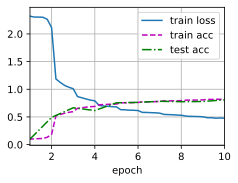

In [20]:
# 训练和评估LeNet-5模型
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结
* 卷积神经⽹络（CNN）是⼀类使⽤卷积层的⽹络。
* 在卷积神经⽹络中，我们组合使⽤卷积层、⾮线性激活函数和汇聚层。
* 为了构造⾼性能的卷积神经⽹络，我们通常对卷积层进⾏排列，逐渐降低其表⽰的空间分辨率，同时增加通道数。
* 在传统的卷积神经⽹络中，卷积块编码得到的表征在输出之前需由⼀个或多个全连接层进⾏处理。
* LeNet是最早发布的卷积神经⽹络之⼀。